# Import libraries: visualization, text analysis and classifiers

In [2]:
import nltk  
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objs as go

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

import nltk
import string
import nltk.corpus
import nltk.stem.snowball
from nltk.corpus import wordnet
# Get default English stopwords and extend with punctuation
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(string.punctuation)
stopwords.append('')



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, ImageColorGenerator

# 1- Preprocessing

In [6]:
from google.colab import files
uploaded=files.upload()

Saving cleaned_hm.csv to cleaned_hm.csv


In [7]:
happy = pd.read_csv('cleaned_hm.csv')
happy.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


total number of missing data per column

In [8]:
happy.isnull().sum(axis = 0)

hmid                         0
wid                          0
reflection_period            0
original_hm                  0
cleaned_hm                   0
modified                     0
num_sentence                 0
ground_truth_category    86410
predicted_category           0
dtype: int64

In [10]:
from google.colab import files
uploaded=files.upload()

Saving demographic.csv to demographic.csv


In [13]:
demographic  = pd.read_csv('demographic.csv')
demographic.head()

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


**clean demographic only once**

In [0]:
# RUN THIS FUNCTION ONLY ONCE AND SAVE demographic_cleaned.csv IN YOUR ACTIVE DIRECTORY
# clean_string function to remove text string but keep number string, float and integer
# For all subsequent analysis, I then import demographic_cleaned.csv directly in order to avoid cleaning data each time.

def clean_string(df, column):
   for i in range(0,len(df)):
       if type(df[column][i])==str:
           df[column][i] = df[column][i].split('.')[0]
           if df[column][i].isdigit()==False:
               df[column][i]=50
   return df
demographic = clean_string(demographic, 'age')

demographic.head(2)
demographic.to_csv("demographic_cleaned.csv", index=False)


**1. Exploratory Data Analysis (EDA) and feature engineering**

1.1 Dataset size and description

In [15]:
happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100535 entries, 0 to 100534
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   hmid                   100535 non-null  int64 
 1   wid                    100535 non-null  int64 
 2   reflection_period      100535 non-null  object
 3   original_hm            100535 non-null  object
 4   cleaned_hm             100535 non-null  object
 5   modified               100535 non-null  bool  
 6   num_sentence           100535 non-null  int64 
 7   ground_truth_category  14125 non-null   object
 8   predicted_category     100535 non-null  object
dtypes: bool(1), int64(3), object(5)
memory usage: 6.2+ MB


In [16]:
demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10844 entries, 0 to 10843
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   wid         10844 non-null  int64 
 1   age         10809 non-null  object
 2   country     10771 non-null  object
 3   gender      10812 non-null  object
 4   marital     10787 non-null  object
 5   parenthood  10813 non-null  object
dtypes: int64(1), object(5)
memory usage: 508.4+ KB


 Merging datasets

In [17]:
happy = pd.merge(happy, demographic, on='wid', validate = 'm:1')
happy.head(3)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,35,USA,m,single,n
1,27873,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1,NaN,leisure,35,USA,m,single,n
2,28073,2053,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1,NaN,leisure,35,USA,m,single,n


# 1. Data import and preparation

In [18]:
happy.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,35,USA,m,single,n
1,27873,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1,NaN,leisure,35,USA,m,single,n
2,28073,2053,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1,NaN,leisure,35,USA,m,single,n
3,33522,2053,24h,Went to see a movie with my friend,Went to see a movie with my friend,True,1,NaN,bonding,35,USA,m,single,n
4,34522,2053,24h,"Played guitar, learning a song on it","Played guitar, learning a song on it",True,1,NaN,leisure,35,USA,m,single,n


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
X = pd.read_csv('/content/gdrive/My Drive/CMPE256/Features.csv')

In [25]:
from google.colab import files
uploaded=files.upload()

Saving Classes.csv to Classes.csv


In [0]:
import pandas as pd

X = pd.read_csv('Features.csv')
y = pd.read_csv('Classes.csv')

** Create Model**

Train Test Split

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=70)

In [0]:
X_train

,hmid,wid,num_sentence,length,age,country,gender,marital,parenthood,reflection_period,003,02,03302017,0430,05052017,06,0600,06th,0800,099,0f,0ld,0ne,10,100,1000,10000,100000,100month,100o,100p,100pound,100th,101,1010,1011,1012,1015,102,10299,...,yt,yugioh,yulli,yum,yummi,yummyyyyyy,zafu,zambreno,zao,zara,zaxbi,zazen,zbrush,zealand,zealous,zelda,zero,zi,ziggi,zillion,zion,zip,zipede,zippo,zit,ziti,zoloft,zombi,zone,zoo,zooit,zoom,zoomust,zootopia,zoow,zoowatch,zoya,zucchini,zumba,zxc
9123,77737,49,2,15,35,1.0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1224,35958,57,1,12,34,1.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11063,46861,1193,1,9,33,0.0,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3176,64513,18,2,19,30,1.0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36939,62659,2406,1,10,38,1.0,1,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15232,55176,201,1,24,34,0.0,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21563,36867,1113,1,4,27,0.0,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25916,67254,1088,1,7,26,0.0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21618,36007,1411,1,15,30,0.0,1,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After trying SVM and Random Forests Random forests worked better

In [0]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
from sklearn.metrics import mean_squared_error, r2_score, f1_score, precision_recall_curve, roc_curve, accuracy_score

Final Model

In [0]:
predictions = clf.predict(X_test)

# 4- Accuracy Measures

In [0]:
accuracy_score(y_test,predictions)

0.7808476059507439

In [0]:
r2_score(y_test,predictions)

0.3828637959445561

In [0]:
from sklearn.metrics import classification_report
target_names = ['exercise','enjoy_the_moment','achievement','nature','bonding','affection','leisure']
print(classification_report(y_test,predictions,target_names =target_names))

                  precision    recall  f1-score   support

        exercise       0.66      0.62      0.64       107
enjoy_the_moment       0.55      0.55      0.55       943
     achievement       0.78      0.80      0.79      2594
          nature       0.53      0.46      0.49       150
         bonding       0.90      0.88      0.89       881
       affection       0.88      0.87      0.88      2696
         leisure       0.63      0.64      0.64       628

        accuracy                           0.78      7999
       macro avg       0.70      0.69      0.70      7999
    weighted avg       0.78      0.78      0.78      7999



In [0]:
"""'achievement'= 3
'affection'= 6
'bonding' = 5
'enjoy_the_moment'=2
'exercise'=1
'leisure'=7
'nature' = 4
"""

"'achievement'= 3\n'affection'= 6\n'bonding' = 5\n'enjoy_the_moment'=2\n'exercise'=1\n'leisure'=7\n'nature' = 4\n"

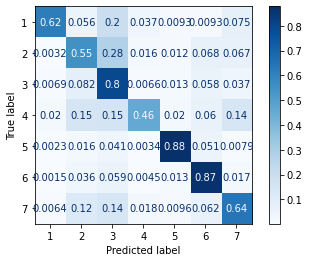

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                             normalize = 'true')


In [0]:
function = clf.decision_path(X_test)

In [0]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = {}
for i in range(1,8):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], function[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(7):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [0]:
from sklearn.preprocessing import label_binarize
new_y =  label_binarize(y_test, classes=[0,1,2,3,4,5,6])

In [0]:
new_y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [0]:
from sklearn.preprocessing import label_binarize
new_y =  label_binarize(y, classes=[0,1,2,3,4,5,6])

In [0]:
X_train, X_test, new_y_train, new_y_test = train_test_split(X, new_y, test_size=0.2, random_state=70)

In [0]:
clf_new = tree.DecisionTreeClassifier()
clf_new.fit(X_train, new_y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
function_new = clf_new.decision_path(X_test)